In [1]:
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, ogr
import os
from datetime import datetime, timedelta
import json

from sentinelhub import AwsProductRequest, AwsTileRequest, AwsTile, WebFeatureService, BBox, CRS, DataSource
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
tile_name = '42MZV'

fulldate = '2016-05-02'
datestrp = datetime.strptime(fulldate, "%Y-%m-%d")
modified_date = datestrp + timedelta(days=1)
newdate = datetime.strftime(modified_date, "%Y-%m-%d")

datestrp = datetime.strptime(fulldate, "%Y-%m-%d")
currentdatemod = datetime.strftime(datestrp, "%Y-%m-%d")
aws_index = 0
gtif_folder = './test/' + tile_name + ',' + currentdatemod + ',' + str(aws_index)


# gtif_folder = './' + tile_name + ',' + fulldate + ',' + str(aws_index)

In [3]:
bands = ['B02', 'B03', 'B04', 'B08']
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
data_folder = './test'

request = AwsTileRequest(tile=tile_name, time=fulldate, aws_index=aws_index, bands=bands, metafiles=metafiles, data_folder=data_folder)
request.save_data()


# newrequest = AwsTileRequest(tile=tile_name, time=fulldate, aws_index=aws_index, bands=bands, metafiles=metafiles, data_folder=data_folder)
# data_list = newrequest.get_data()
# b02, b03, b04, b08, tile_info, preview, cloud_mask = data_list

<class 'numpy.uint16'>


<IPython.core.display.Javascript object>


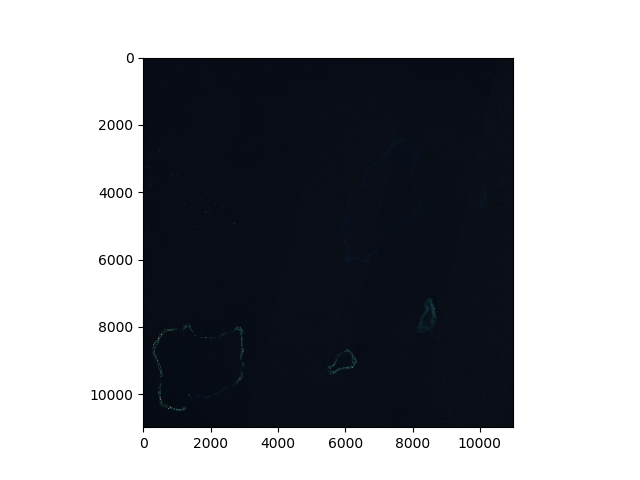

In [45]:
wholeimg = np.zeros((b02.shape[0], b02.shape[1], 3))
print(type(b02[0][0]))
wholeimg[:,:,0] = b04/10000
wholeimg[:,:,1] = b03/10000
wholeimg[:,:,2] = b02/10000

wholeimg[wholeimg > 1] = 1

plt.figure(1)
plt.imshow(wholeimg)
plt.show()

In [46]:
# Temp Cloud Rasterize
inpath = gtif_folder + "/qi/MSK_CLOUDS_B00.gml"
jsonpath = gtif_folder + "/tileInfo.json"
outpath = gtif_folder  + "/test.shp"

jsondata = json.load(open(jsonpath))
STL_xmin = jsondata["tileGeometry"]["coordinates"][0][0][0]
STL_xmax = jsondata["tileGeometry"]["coordinates"][0][1][0]
STL_ymin = jsondata["tileGeometry"]["coordinates"][0][2][1]
STL_ymax = jsondata["tileGeometry"]["coordinates"][0][0][1]

inDriver = ogr.GetDriverByName("GML")
inDataSource = inDriver.Open(inpath, 0)

source_layer = inDataSource.GetLayer()
field_vals = list(set([feature.GetFieldAsString('maskType') for feature in source_layer])) #this includes all polygons, but condensed into a set
# STL_xmin, STL_xmax, STL_ymin, STL_ymax = source_layer.GetExtent()
NoData_value = -1
STL_pixel_size = 10
STL_xres = int((STL_xmax - STL_xmin) / STL_pixel_size)
STL_yres = int((STL_ymax - STL_ymin) / STL_pixel_size)
target_ds = gdal.GetDriverByName('GTiff').Create('STL_tempcloud.tif', STL_xres, STL_yres, gdal.GDT_Byte)
target_ds.SetGeoTransform((STL_xmin, STL_pixel_size, 0, STL_ymax, 0, -STL_pixel_size))

band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)
err = gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
# err = gdal.RasterizeLayer(target_ds, [1], source_layer, None, None, [0], options=['ALL_TOUCHED=TRUE','ATTRIBUTE=maskType'])
inDriver = None
inDataSource = None
target_ds = None

TypeError: 'NoneType' object is not iterable

In [34]:
# Worldview-2 Data
WorldView2Path = 'BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tif'
tfwPath = 'BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tfw'

img = gdal.Open(WorldView2Path)
try:
    WV2_projection = img.GetProjection()
except Exception:
    pass
WV2_xsize = img.RasterXSize
WV2_ysize = img.RasterYSize

if tfwPath is not None:
    tfw_info = np.asarray([float(line.rstrip('\n')) for line in open(tfwPath)]).astype(np.float32)
    # top left x, w-e pixel resolution, 0, top left y, 0, n-s pixel resolution (negative)
    WV2_geotransform = np.asarray([tfw_info[4], tfw_info[0], tfw_info[1], tfw_info[5], tfw_info[2], tfw_info[3]])
else:
    WV2_geotransform = img.GetGeoTransform()
WV2_pixel_size = WV2_geotransform[1]
WV2_xmin = WV2_geotransform[0]
WV2_ymax = WV2_geotransform[3]
print('%.15f' % WV2_ymax)

WV2_image = np.zeros((WV2_ysize,WV2_xsize,img.RasterCount))

for band in range(img.RasterCount):
    band += 1
    imgband = img.GetRasterBand(band)
    WV2_image[:,:,band-1] = imgband.ReadAsArray()
img = None

9421399.000000000000000


In [48]:
STL_pixel_size = 10

WV2_xstart = np.max([0, int((STL_xmin - WV2_xmin)/WV2_pixel_size)])
STL_xstart = np.max([0, int((WV2_xmin - STL_xmin)/STL_pixel_size)])
STL_ystart = np.max([0, int((STL_ymax - WV2_ymax)/STL_pixel_size)])
WV2_ystart = np.max([0, int((WV2_ymax - STL_ymax)/WV2_pixel_size)])

total_cols = int((np.min([WV2_xsize*WV2_pixel_size + WV2_xmin, STL_xmax]) - np.max([WV2_xmin, STL_xmin]))/STL_pixel_size)
total_rows = int((np.min([WV2_ymax, STL_ymax]) - np.max([-WV2_ysize*WV2_pixel_size + WV2_ymax, STL_ymin]))/STL_pixel_size)

# Band data
target_ds = gdal.GetDriverByName('GTiff').Create('STL_4band_' + currentdatemod + '.tif', total_cols, total_rows, 4, gdal.GDT_Int16)
target_ds.SetGeoTransform((WV2_xmin, STL_pixel_size, 0, WV2_ymax, 0, -STL_pixel_size))
target_ds.GetRasterBand(1).WriteArray(b04[STL_ystart:STL_ystart+total_rows, STL_xstart:STL_xstart+total_cols])
target_ds.GetRasterBand(1).SetNoDataValue(NoData_value)
target_ds.GetRasterBand(2).WriteArray(b03[STL_ystart:STL_ystart+total_rows, STL_xstart:STL_xstart+total_cols])
target_ds.GetRasterBand(2).SetNoDataValue(NoData_value)
target_ds.GetRasterBand(3).WriteArray(b02[STL_ystart:STL_ystart+total_rows, STL_xstart:STL_xstart+total_cols])
target_ds.GetRasterBand(3).SetNoDataValue(NoData_value)
target_ds.GetRasterBand(4).WriteArray(b08[STL_ystart:STL_ystart+total_rows, STL_xstart:STL_xstart+total_cols])
target_ds.GetRasterBand(4).SetNoDataValue(NoData_value)
target_ds.FlushCache()  # Write to disk.
target_ds = None

#fixed_image = self.image[image_ystart:image_ystart+total_rows, image_xstart:image_xstart+total_cols, :]
#self.truthimage = self.truthimage[truth_ystart:truth_ystart+total_rows, truth_xstart:truth_xstart+total_cols]

In [41]:
cloudpath = 'STL_tempcloud.tif'
img = gdal.Open(cloudpath)
imgband = img.GetRasterBand(1)
tempcloudimg = imgband.ReadAsArray()
img = None

target_ds = gdal.GetDriverByName('GTiff').Create('STL_Cloud_' + currentdatemod + '.tif', total_cols, total_rows, 1, gdal.GDT_Int16)
target_ds.SetGeoTransform((WV2_xmin, STL_pixel_size, 0, WV2_ymax, 0, -STL_pixel_size))
target_ds.GetRasterBand(1).WriteArray(tempcloudimg[STL_ystart:STL_ystart+total_rows, STL_xstart:STL_xstart+total_cols])
target_ds.GetRasterBand(1).SetNoDataValue(NoData_value)
target_ds = None


810673.0
799980.0
9.4214e+06
9500020.0
909780.0
9390220.0
866
654
1069
7862


<IPython.core.display.Javascript object>


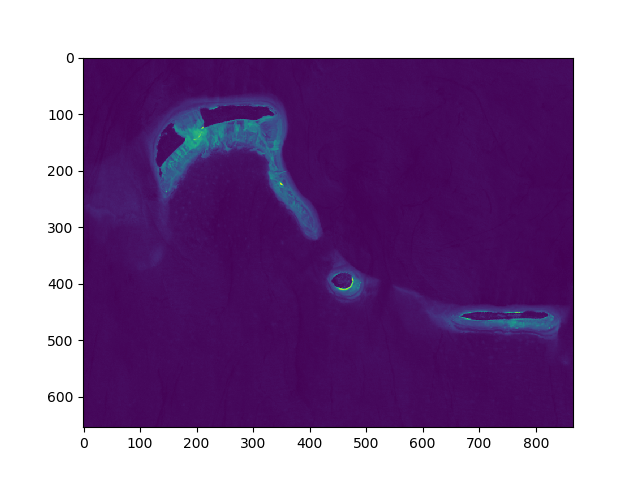

In [49]:
print(WV2_xmin)
print(STL_xmin)
print(WV2_ymax)
print(STL_ymax)
print(STL_xmax)
print(STL_ymin)

print(total_cols)
print(total_rows)
print(STL_xstart)
print(STL_ystart)

plt.figure(2)
plt.imshow(b02[STL_ystart:STL_ystart+total_rows, STL_xstart:STL_xstart+total_cols]/10000)
plt.show()
